In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
from torch.utils.data import DataLoader
# Add the path to utils.py
sys.path.append(r"c:\Document\Serieux\Travail\python_work\cEBNM_torch\py")

# Import utils.py directly
from utils import *
from numerical_routine import *
from distribution_operation import *
from posterior_computation import *

# Set random seed for reproducibility
np.random.seed(1)
torch.manual_seed(1)

batch_size=128
# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
mnist_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
data_loader = DataLoader(mnist_data, batch_size=batch_size , shuffle=True)

# Function to generate y values
def generate_y(t, is_even):
     
    if is_even:        
        if t <0 :
         return  np.random.normal(0, 2 )
        else :
            return np.zeros_like(t)
    else:
        if t>0:
            return np.random.normal(0, 2 )
        else :
            return  np.zeros_like(t)
        
 
# Custom Dataset class to handle MNIST images and simulated data
class SimulatedMNISTDataset(Dataset):
    def __init__(self, mnist_data, positions, y_values, y_noisy, digits, noise_level, label_type, image_label):
        self.image = mnist_data 
        self.mnist_data = mnist_data
        self.positions = torch.tensor(positions, dtype=torch.float32)
        self.y_values = torch.tensor(y_values, dtype=torch.float32)
        self.y_noisy = torch.tensor(y_noisy, dtype=torch.float32)
        self.digits = torch.tensor(digits, dtype=torch.long)
        self.noise_level = noise_level
        self.label_type = label_type
        self.image_label=image_label
        self.scale = autoselect_scales_mix_norm(
            betahat=np.array(self.y_noisy),
            sebetahat=np.array(self.noise_level)
        )
        
        self.Lim =torch.tensor(  get_data_loglik_normal(
            betahat=np.array(self.y_noisy),
            sebetahat=np.array(self.noise_level),
            location=0,
            scale=self.scale
                     ) , dtype=torch.float32)

    def __len__(self):
        return len(self.mnist_data)

    
    def __getitem__(self, idx):
        image, _ = self.mnist_data[idx]
        position = self.positions[idx]
        y_value = self.y_values[idx]
        y_noisy = self.y_noisy[idx]
        digit = self.digits[idx]
        marginal_log_lik = self.Lim[idx]
        
        return image, digit, position, y_value, y_noisy, marginal_log_lik
    

        



In [2]:
# Generate the simulated dataset
n_samples = 50000
noise_level = 1
positions = []
y_values = []
digits = []
y_noisy = []
label_type= []
image_label =[]
# Ensure unique indices are used
unique_indices = np.random.choice(len(mnist_data), size=n_samples, replace=False)
filtered_mnist_data = torch.utils.data.Subset(mnist_data, unique_indices)

# Run simulation to generate noisy data
for idx in unique_indices:
    image, label = mnist_data[idx]
    t = np.random.uniform(-0.5, 0.5)
    is_even = label % 2 == 0
    y = generate_y(t, is_even)
    noise = np.random.normal(0, noise_level)
    y_noisy_value = y + noise
    positions.append(t)
    y_values.append(y)
    y_noisy.append(y_noisy_value)
    digits.append(label)
    image_label.append(label)
    label_type.append(is_even)
    
positions = np.array(positions)
y_values = np.array(y_values)
y_noisy = np.array(y_noisy)
digits = np.array(digits)
label_type = np.array(label_type)
image_label = np.array(image_label)
noiseless=y_values
# Create custom dataset with the filtered MNIST dataset and simulated data
simulated_dataset = SimulatedMNISTDataset(
    mnist_data=filtered_mnist_data,
    positions=positions,
    y_values=y_values,
    y_noisy=y_noisy,
    digits=digits,
    noise_level=np.repeat(1, y_noisy.shape[0]),
    label_type=label_type,
    image_label =image_label
)


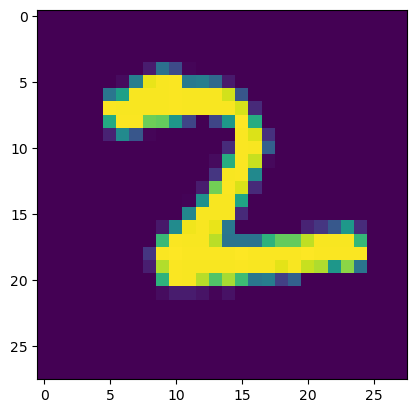

In [3]:
img, label =simulated_dataset.mnist_data[1]
img
plt.imshow(img.squeeze())

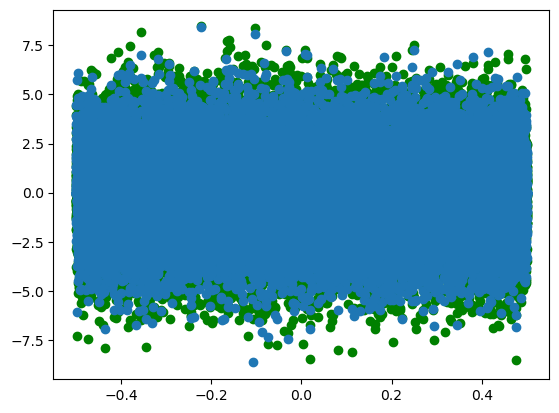

In [4]:
positions =simulated_dataset.positions
y_values = simulated_dataset.y_values
y_noisy = simulated_dataset.y_noisy

plt.scatter(positions, y_noisy, color="green")
plt.scatter(positions,y_values)

In [5]:
 
L_im = simulated_dataset.Lim
print(L_im [0])
scale= autoselect_scales_mix_norm(betahat=np.array(y_noisy),
                             sebetahat=np.repeat(1, y_noisy.shape[0]))
print(get_data_loglik_normal(y_noisy,  location=0,
                             sebetahat=np.repeat(1, y_noisy.shape[0]),
                             scale=scale)[0,])
      
 
n_epoch = 20
batch_size =128


tensor([-9.9796, -9.9424, -9.8327, -9.4215, -8.1232, -5.5716, -3.4243, -2.8679,
        -3.1861, -3.7807])
[-9.97964624 -9.94241715 -9.8327038  -9.42150697 -8.1232224  -5.57158147
 -3.4243323  -2.86791433 -3.18607763 -3.78071764]


In [6]:
# MLP-VAE model
class MLP_VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, output_dim):
        super(MLP_VAE, self).__init__()

        # Encoder: MLP to encode the input image and produce latent variables
        self.encoder = nn.Sequential(
            nn.Linear(input_dim + 1, hidden_dim),  # +1 for position
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
        )

        # Latent variable layers (mean and log variance)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)       # Mean of the latent space
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)   # Log variance of the latent space

        # Decoder: MLP to decode the latent space back to the output fitted pi values
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim + 1, hidden_dim),  # +1 for position
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def encode(self, x, pos):
        x = x.view(x.size(0), -1)  # Flatten the input image
        input_tensor = torch.cat([x, pos], dim=1)
        x_encoded = self.encoder(input_tensor)
        mu = self.fc_mu(x_encoded)
        logvar = self.fc_logvar(x_encoded)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, pos):
        z = torch.cat([z, pos], dim=1)
        return F.softmax(self.decoder(z), dim=1)

    def forward(self, x, pos):
        mu, logvar = self.encode(x, pos)
        z = self.reparameterize(mu, logvar)
        pred_pi = self.decode(z, pos)
        return pred_pi, mu, logvar


# Loss function for VAE with KL divergence
def vae_loss_function(pred_pi, marginal_log_lik, mu, logvar, beta=1.0):
    """
    VAE Loss = Reconstruction Loss + KL Divergence
    beta is the weight for the KL divergence term (for β-VAE)
    """
    # Reconstruction loss: similar to the loss function defined previously
    log_likelihood = torch.log(torch.sum(torch.exp(marginal_log_lik) * pred_pi, dim=1))
    reconstruction_loss = -torch.sum(log_likelihood)

    # KL divergence: regularizing the latent space distribution to be close to standard normal
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return reconstruction_loss + beta * kl_divergence


# Training function
def train(model, device, train_loader, optimizer, epoch, beta=1.0):
    model.train()
    train_loss = 0
    for batch_idx, (data, digit, pos, y_value, y_noisy, marginal_log_lik) in enumerate(train_loader):
        data, pos, marginal_log_lik = data.to(device), pos.to(device), marginal_log_lik.to(device)
        optimizer.zero_grad()
        pred_pi, mu, logvar = model(data, pos.unsqueeze(1)) 
        loss = vae_loss_function(pred_pi, marginal_log_lik, mu, logvar, beta=beta)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                  f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item() / len(data):.6f}')
    
    print(f'====> Epoch: {epoch} Average loss: {train_loss / len(train_loader.dataset):.4f}')


# Visualization of Latent Space
def visualize_latent_space(model, device, data_loader):
    model.eval()
    with torch.no_grad():
        latents = []
        labels = []
        for data, digit, pos, y_value, y_noisy, marginal_log_lik in data_loader:
            data, pos = data.to(device), pos.to(device)
            mu, logvar = model.encode(data, pos.unsqueeze(1))
            z = model.reparameterize(mu, logvar)
            latents.append(z.cpu().numpy())
            labels.append(digit.numpy())
    
    latents = np.concatenate(latents)
    labels = np.concatenate(labels)

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(latents[:, 0], latents[:, 1], c=labels, cmap='tab10')
    plt.colorbar(scatter)
    plt.title("Latent Space Visualization")
    plt.xlabel("Latent Dimension 1")
    plt.ylabel("Latent Dimension 2")
    plt.show()

 

input_dim = 784  # MNIST images (28x28)
hidden_dim = 400
latent_dim =20
# Main training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MLP_VAE(input_dim=input_dim,
                hidden_dim=hidden_dim,
                latent_dim=latent_dim,
                output_dim= simulated_dataset.Lim.size()[1]).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

train_loader = DataLoader(simulated_dataset, batch_size=batch_size , shuffle=True)

for epoch in range(1, n_epoch + 1):
    train(model, device, train_loader, optimizer, epoch)

# Evaluation on training set


Train Epoch: 1 [0/50000 (0%)]	Loss: 2.095138
Train Epoch: 1 [12800/50000 (26%)]	Loss: 1.957379
Train Epoch: 1 [25600/50000 (51%)]	Loss: 1.936505
Train Epoch: 1 [38400/50000 (77%)]	Loss: 1.823920
====> Epoch: 1 Average loss: 1.9423
Train Epoch: 2 [0/50000 (0%)]	Loss: 2.051301
Train Epoch: 2 [12800/50000 (26%)]	Loss: 2.013721
Train Epoch: 2 [25600/50000 (51%)]	Loss: 2.048480
Train Epoch: 2 [38400/50000 (77%)]	Loss: 1.861518
====> Epoch: 2 Average loss: 1.9390
Train Epoch: 3 [0/50000 (0%)]	Loss: 1.974933
Train Epoch: 3 [12800/50000 (26%)]	Loss: 1.860664
Train Epoch: 3 [25600/50000 (51%)]	Loss: 1.855363
Train Epoch: 3 [38400/50000 (77%)]	Loss: 1.894195
====> Epoch: 3 Average loss: 1.9386
Train Epoch: 4 [0/50000 (0%)]	Loss: 1.927759
Train Epoch: 4 [12800/50000 (26%)]	Loss: 1.882196
Train Epoch: 4 [25600/50000 (51%)]	Loss: 2.056642
Train Epoch: 4 [38400/50000 (77%)]	Loss: 1.946168
====> Epoch: 4 Average loss: 1.9384
Train Epoch: 5 [0/50000 (0%)]	Loss: 1.844856
Train Epoch: 5 [12800/50000 (26

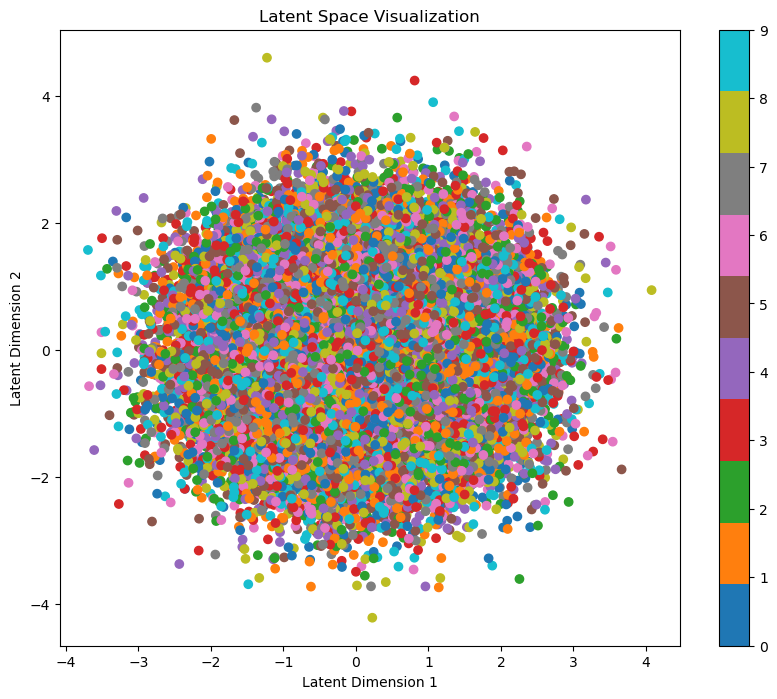

In [10]:
visualize_latent_space (model, device, train_loader)

In [ ]:
# Plotting
plt.figure(figsize=(15, 5))

# Plot 1: Est Post vs Y Noisy
plt.subplot(1, 4, 1)
plt.scatter(est_post, all_y_noisy, alpha=0.5, s=1)
plt.title('Est Post vs Y Noisy')
plt.xlabel('Est Post')
plt.ylabel('Y Noisy')
plt.plot([min(est_post), max(est_post)], [min(est_post), max(est_post)], 'r--')

# Plot 2: Est Post vs Y True
plt.subplot(1, 4, 2)
plt.scatter(all_y_noisy, all_y_true, alpha=0.5, s=1, label='Y Noisy', color='red')

plt.scatter(est_post, all_y_true, alpha=0.5, s=1, label='Y True', color='blue')
plt.title('Est Post vs Y True and Y Noisy')
plt.xlabel('Est Post / Y Noisy')
plt.ylabel('Y True')
plt.legend()
plt.plot([min(est_post), max(est_post)], [min(est_post), max(est_post)], 'r--')

# Plot 3: Positions vs Est Post, Y True, and Y Noisy
plt.subplot(1, 4, 3)
plt.scatter(all_positions, all_y_true, alpha=0.5, s=1, label='Y True', color='blue')
plt.scatter(all_positions, est_post, alpha=0.5, s=1, label='Est Post', color='red') 
plt.title('Positions vs Est Post, Y True ')
plt.xlabel('Positions')
plt.ylabel('Values')
plt.legend()

plt.subplot(1, 4, 4)

plt.scatter(all_positions, all_y_noisy, alpha=0.5, s=1, label='Y Noisy', color='green')
plt.scatter(all_positions, all_y_true, alpha=0.5, s=1, label='Y True', color='blue') 
plt.title('Positions vs Y True, and Y Noisy')
plt.xlabel('Positions')
plt.ylabel('Values')
plt.legend()


plt.tight_layout()
plt.show()

 
# Calculate and print MSE
mse_noisy = np.mean((all_y_true - all_y_noisy)**2)
mse_est = np.mean((est_post - all_y_true)**2)
print(f"\nMean Squared Error:")
print(f"MSE (Y Noisy vs Y True): {mse_noisy:.4f}")
print(f"MSE (Est Post vs Y True): {mse_est:.4f}")

In [17]:
# Function to get the fitted pi values on the training data
def get_fitted_pi(model, device, data_loader):
    model.eval()
    all_pi = []
    all_labels = []

    with torch.no_grad():
        for data, digit, pos, _, _, _ in data_loader:
            data, pos = data.to(device), pos.to(device).unsqueeze(1)
            pred_pi, _, _ = model(data, pos)  # Get the predicted pi from the model
            all_pi.append(pred_pi.detach().cpu())  # Move the fitted pi values to CPU and detach
            all_labels.append(digit.cpu())  # Collect the labels

    # Concatenate all fitted pi values and labels
    all_pi = torch.cat(all_pi)
    all_labels = torch.cat(all_labels)
    
    return all_pi, all_labels

# Call this function after training to get the fitted pi values
fitted_pi, labels = get_fitted_pi(model, device, train_loader)

# Print some of the fitted pi values for the first few samples
print("Fitted pi values for the first few samples:")
print(fitted_pi[:10])
print("Corresponding labels for the first few samples:")
print(labels[:10])


Fitted pi values for the first few samples:
tensor([[1.0472e-02, 9.8858e-03, 8.9167e-02, 3.4255e-01, 1.4359e-02, 1.4250e-01,
         3.9054e-01, 5.1356e-04, 1.4481e-05, 3.9991e-06],
        [5.1010e-03, 4.7424e-03, 7.3439e-02, 3.6951e-01, 7.1944e-03, 1.2673e-01,
         4.1316e-01, 1.2606e-04, 5.9027e-07, 6.8032e-08],
        [5.4299e-03, 5.0562e-03, 7.4836e-02, 3.6797e-01, 7.5951e-03, 1.2739e-01,
         4.1158e-01, 1.4544e-04, 7.0834e-07, 8.3689e-08],
        [2.0622e-03, 1.9096e-03, 5.4661e-02, 3.9945e-01, 3.0966e-03, 1.0927e-01,
         4.2953e-01, 2.0766e-05, 2.0930e-08, 1.2004e-09],
        [1.3503e-02, 1.2776e-02, 9.5648e-02, 3.3075e-01, 1.8052e-02, 1.4713e-01,
         3.8124e-01, 8.5121e-04, 3.5583e-05, 1.1338e-05],
        [6.8918e-03, 6.3941e-03, 7.9939e-02, 3.5920e-01, 9.5696e-03, 1.3121e-01,
         4.0657e-01, 2.2186e-04, 1.9856e-06, 2.9397e-07],
        [3.2650e-03, 3.0188e-03, 6.3768e-02, 3.8650e-01, 4.7196e-03, 1.1795e-01,
         4.2073e-01, 4.9902e-05, 1.1407e-

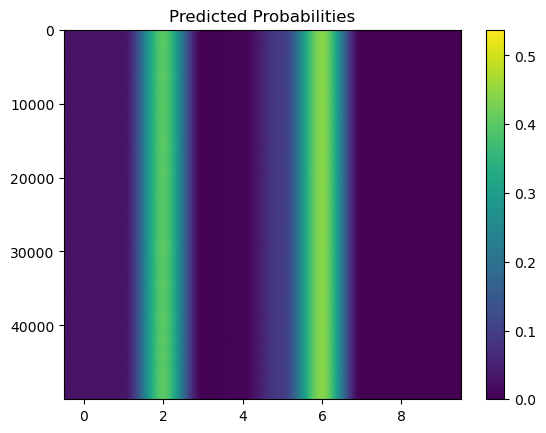

In [22]:
plt.imshow(fitted_pi, aspect='auto')
plt.title('Predicted Probabilities')
plt.colorbar()

In [11]:
import sys
import os
import matplotlib.pyplot as plt

# Add the path to utils.py
sys.path.append(r"c:\Document\Serieux\Travail\python_work\cEBNM_torch\py")
from distribution_operation import *
from utils import *
from numerical_routine import *
from posterior_computation import *
from ash import *
print(np.repeat(noise_level, y_noisy.shape[0]))
betahat =  np.array(simulated_dataset.y_noisy )

sebetahat =  np.repeat(noise_level, betahat.shape[0])
print(sebetahat)
res= ash(betahat=betahat,
         sebetahat= sebetahat, penalty=2)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[1 1 1 ... 1 1 1]


In [9]:
mse_ash = np.mean((res.post_mean - all_y_true)**2)
print(res.pi)

[3.11061730e-01 1.15305048e-01 4.41816650e-02 1.91288576e-02
 1.34528998e-02 4.97923887e-02 4.47060433e-01 1.69782503e-05
 4.44080328e-21 0.00000000e+00]


In [10]:
print(f"\nMean Squared Error:")
print(f"MSE (Y Noisy vs Y True): {mse_noisy:.4f}")
print(f"MSE (Est Post vs Y True): {mse_est:.4f}")
print(f"MSE (ash Est Post vs Y True): {mse_ash:.4f}")



Mean Squared Error:
MSE (Y Noisy vs Y True): 0.9974
MSE (Est Post vs Y True): 0.4855
MSE (ash Est Post vs Y True): 0.5876


NameError: name 'est_post' is not defined

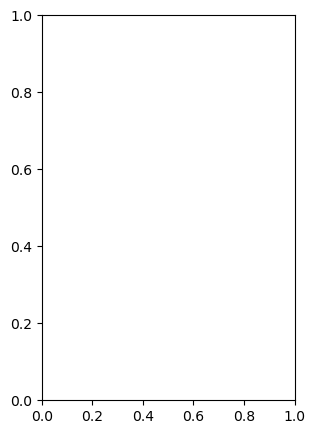

In [21]:

idx= simulated_dataset.label_type

# Plotting
plt.figure(figsize=(15, 5))

# Plot 1: Est Post vs Y Noisy
plt.subplot(1, 4, 1)
plt.scatter(est_post[idx],res.post_mean[idx], alpha=0.5, s=1)
plt.title('Est Post vs ash post mean')
plt.xlabel('Est Post')
plt.ylabel('ash post')
plt.plot([min(est_post), max(est_post)], [min(est_post), max(est_post)], 'r--')

# Plot 2: Est Post vs Y True
plt.subplot(1, 4, 2)
plt.scatter(res.post_mean[idx], all_y_true[idx], alpha=0.5, s=1, label='Y Noisy', color='red')

plt.scatter(est_post[idx], all_y_true[idx], alpha=0.5, s=1, label='Y True', color='blue')
plt.title('Est Post vs Y True and ash post mean')
plt.xlabel('Est Post / Y Noisy')
plt.ylabel('Y True')
plt.legend()
plt.plot([min(est_post), max(est_post)], [min(est_post), max(est_post)], 'r--')

# Plot 3: Positions vs Est Post, Y True, and Y Noisy
plt.subplot(1, 4, 3)
plt.scatter(all_positions[idx], all_y_true[idx], alpha=0.5, s=1, label='Y True', color='blue')
plt.scatter(all_positions[idx], est_post[idx], alpha=0.5, s=1, label='Est Post', color='red') 
plt.title('Positions vs Est Post, Y True ')
plt.xlabel('Positions')
plt.ylabel('Values')
plt.legend()

plt.subplot(1, 4, 4)

plt.scatter(all_positions[idx],res.post_mean[idx], alpha=0.5, s=1, label='Y Noisy', color='green')
plt.scatter(all_positions[idx], all_y_true[idx], alpha=0.5, s=1, label='Y True', color='blue') 
plt.title('Positions vs Y True, and Y Noisy')
plt.xlabel('Positions')
plt.ylabel('Values')
plt.legend()


plt.tight_layout()
plt.show()

 
# Calculate and print MSE

# Calculate and print MSE
mse_noisy = np.mean((all_y_true[idx] - all_y_noisy[idx])**2)
mse_est = np.mean((est_post[idx] - all_y_true[idx])**2)

mse_ash  = np.mean((res.post_mean[idx] - all_y_true[idx])**2)
print(f"\nMean Squared Error:")
print(f"MSE (Y Noisy vs Y True): {mse_noisy:.4f}")
print(f"MSE (Est Post vs Y True): {mse_est:.4f}")

print(f"MSE (Est Post vs Y True): {mse_ash:.4f}")

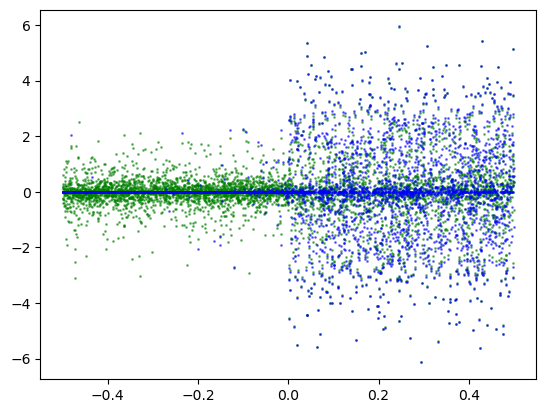

In [12]:
idx =simulated_dataset.image_label    ==7
plt.scatter(all_positions[idx],res.post_mean[idx], alpha=0.5, s=1, label='Y Noisy', color='green')
plt.scatter(all_positions[idx],est_post[idx], alpha=0.5, s=1, label='Y True', color='blue') 

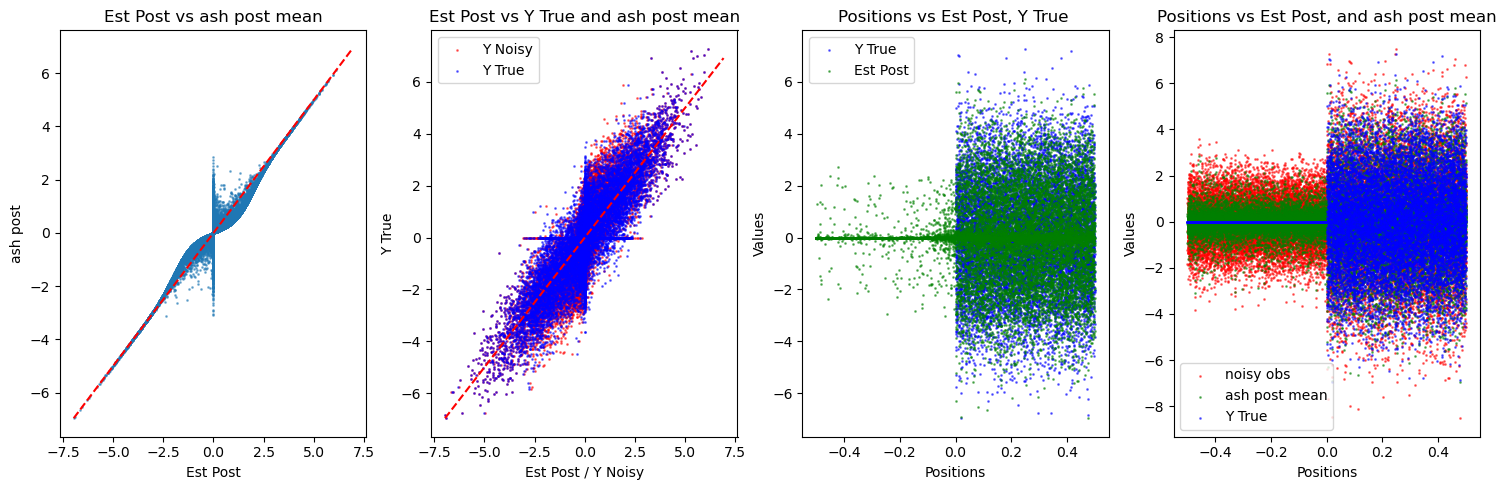


Mean Squared Error:
MSE (Y Noisy vs Y True): 0.9870
MSE (Est Post vs Y True): 0.4835
MSE (Est Post vs Y True): 0.5834


In [13]:

idx=  ~simulated_dataset.label_type
 
# Plotting
plt.figure(figsize=(15, 5))

# Plot 1: Est Post vs Y Noisy
plt.subplot(1, 4, 1)
plt.scatter(est_post[idx],res.post_mean[idx], alpha=0.5, s=1)
plt.title('Est Post vs ash post mean')
plt.xlabel('Est Post')
plt.ylabel('ash post')
plt.plot([min(est_post), max(est_post)], [min(est_post), max(est_post)], 'r--')

# Plot 2: Est Post vs Y True
plt.subplot(1, 4, 2)
plt.scatter(res.post_mean[idx], all_y_true[idx], alpha=0.5, s=1, label='Y Noisy', color='red')

plt.scatter(est_post[idx], all_y_true[idx], alpha=0.5, s=1, label='Y True', color='blue')
plt.title('Est Post vs Y True and ash post mean')
plt.xlabel('Est Post / Y Noisy')
plt.ylabel('Y True')
plt.legend()
plt.plot([min(est_post), max(est_post)], [min(est_post), max(est_post)], 'r--')

# Plot 3: Positions vs Est Post, Y True, and Y Noisy
plt.subplot(1, 4, 3) 

plt.scatter(all_positions[idx], all_y_true[idx], alpha=0.5, s=1, label='Y True', color='blue')
plt.scatter(all_positions[idx], est_post[idx], alpha=0.5, s=1, label='Est Post', color='green') 
plt.title('Positions vs Est Post, Y True ')
plt.xlabel('Positions')
plt.ylabel('Values')
plt.legend()

plt.subplot(1, 4, 4)

plt.scatter(all_positions[idx],all_y_noisy[idx], alpha=0.5, s=1, label='noisy obs', color='red')
plt.scatter(all_positions[idx],res.post_mean[idx], alpha=0.5, s=1, label='ash post mean', color='green')
plt.scatter(all_positions[idx], all_y_true[idx], alpha=0.5, s=1, label='Y True', color='blue') 
plt.title('Positions vs Est Post, and ash post mean')
plt.xlabel('Positions')
plt.ylabel('Values')
plt.legend()


plt.tight_layout()
plt.show()

 
# Calculate and print MSE

# Calculate and print MSE
mse_noisy = np.mean((all_y_true[idx] - all_y_noisy[idx])**2)
mse_est = np.mean((est_post[idx] - all_y_true[idx])**2)

mse_ash  = np.mean((res.post_mean[idx] - all_y_true[idx])**2)
print(f"\nMean Squared Error:")
print(f"MSE (Y Noisy vs Y True): {mse_noisy:.4f}")
print(f"MSE (Est Post vs Y True): {mse_est:.4f}")

print(f"MSE (Est Post vs Y True): {mse_ash:.4f}")

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.112590
Train Epoch: 1 [12800/50000 (26%)]	Loss: 1.974069
Train Epoch: 1 [25600/50000 (51%)]	Loss: 1.857204
Train Epoch: 1 [38400/50000 (77%)]	Loss: 2.011140
====> Epoch: 1 Average loss: 1.9426
Train Epoch: 2 [0/50000 (0%)]	Loss: 1.930783
Train Epoch: 2 [12800/50000 (26%)]	Loss: 1.969874
Train Epoch: 2 [25600/50000 (51%)]	Loss: 1.999393
Train Epoch: 2 [38400/50000 (77%)]	Loss: 2.060291
====> Epoch: 2 Average loss: 1.9386
Train Epoch: 3 [0/50000 (0%)]	Loss: 1.881121
Train Epoch: 3 [12800/50000 (26%)]	Loss: 1.882699
Train Epoch: 3 [25600/50000 (51%)]	Loss: 1.806829
Train Epoch: 3 [38400/50000 (77%)]	Loss: 1.956560
====> Epoch: 3 Average loss: 1.9382
Train Epoch: 4 [0/50000 (0%)]	Loss: 1.914891
Train Epoch: 4 [12800/50000 (26%)]	Loss: 1.782220
Train Epoch: 4 [25600/50000 (51%)]	Loss: 1.975049
Train Epoch: 4 [38400/50000 (77%)]	Loss: 1.914409
====> Epoch: 4 Average loss: 1.9379
Train Epoch: 5 [0/50000 (0%)]	Loss: 1.779442
Train Epoch: 5 [12800/50000 (26

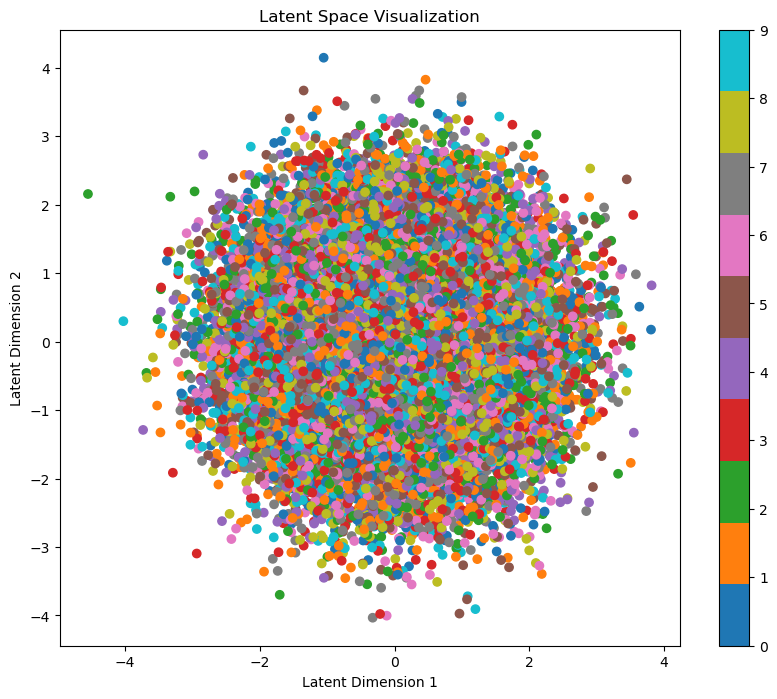

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt

# Custom Dataset class (same as before)
class SimulatedMNISTDataset(Dataset):
    def __init__(self, mnist_data, positions, y_values, y_noisy, digits, noise_level, label_type, image_label):
        self.mnist_data = mnist_data
        self.positions = torch.tensor(positions, dtype=torch.float32)
        self.y_values = torch.tensor(y_values, dtype=torch.float32)
        self.y_noisy = torch.tensor(y_noisy, dtype=torch.float32)
        self.digits = torch.tensor(digits, dtype=torch.long)
        self.noise_level = noise_level
        self.label_type = label_type
        self.image_label = image_label
        self.scale = autoselect_scales_mix_norm(
            betahat=np.array(self.y_noisy),
            sebetahat=np.array(self.noise_level)
        )

        self.Lim = torch.tensor(get_data_loglik_normal(
            betahat=np.array(self.y_noisy),
            sebetahat=np.array(self.noise_level),
            location=0,
            scale=self.scale
        ), dtype=torch.float32)

    def __len__(self):
        return len(self.mnist_data)

    def __getitem__(self, idx):
        image, _ = self.mnist_data[idx]
        position = self.positions[idx]
        y_value = self.y_values[idx]
        y_noisy = self.y_noisy[idx]
        digit = self.digits[idx]
        marginal_log_lik = self.Lim[idx]
        return image, digit, position, y_value, y_noisy, marginal_log_lik


# MLP-VAE model
class MLP_VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, output_dim):
        super(MLP_VAE, self).__init__()

        # Encoder: MLP to encode the input image and produce latent variables
        self.encoder = nn.Sequential(
            nn.Linear(input_dim + 1, hidden_dim),  # +1 for position
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
        )

        # Latent variable layers (mean and log variance)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)       # Mean of the latent space
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)   # Log variance of the latent space

        # Decoder: MLP to decode the latent space back to the output fitted pi values
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim + 1, hidden_dim),  # +1 for position
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def encode(self, x, pos):
        x = x.view(x.size(0), -1)  # Flatten the input image
        input_tensor = torch.cat([x, pos], dim=1)
        x_encoded = self.encoder(input_tensor)
        mu = self.fc_mu(x_encoded)
        logvar = self.fc_logvar(x_encoded)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, pos):
        z = torch.cat([z, pos], dim=1)
        return F.softmax(self.decoder(z), dim=1)

    def forward(self, x, pos):
        mu, logvar = self.encode(x, pos)
        z = self.reparameterize(mu, logvar)
        pred_pi = self.decode(z, pos)
        return pred_pi, mu, logvar


# Loss function for VAE with KL divergence
def vae_loss_function(pred_pi, marginal_log_lik, mu, logvar, beta=1.0):
    """
    VAE Loss = Reconstruction Loss + KL Divergence
    beta is the weight for the KL divergence term (for β-VAE)
    """
    # Reconstruction loss: similar to the loss function defined previously
    log_likelihood = torch.log(torch.sum(torch.exp(marginal_log_lik) * pred_pi, dim=1))
    reconstruction_loss = -torch.sum(log_likelihood)

    # KL divergence: regularizing the latent space distribution to be close to standard normal
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return reconstruction_loss + beta * kl_divergence


# Training function
def train(model, device, train_loader, optimizer, epoch, beta=1.0):
    model.train()
    train_loss = 0
    for batch_idx, (data, digit, pos, y_value, y_noisy, marginal_log_lik) in enumerate(train_loader):
        data, pos, marginal_log_lik = data.to(device), pos.to(device), marginal_log_lik.to(device)
        optimizer.zero_grad()
        pred_pi, mu, logvar = model(data, pos.unsqueeze(1)) 
        loss = vae_loss_function(pred_pi, marginal_log_lik, mu, logvar, beta=beta)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                  f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item() / len(data):.6f}')
    
    print(f'====> Epoch: {epoch} Average loss: {train_loss / len(train_loader.dataset):.4f}')


# Visualization of Latent Space
def visualize_latent_space(model, device, data_loader):
    model.eval()
    with torch.no_grad():
        latents = []
        labels = []
        for data, digit, pos, y_value, y_noisy, marginal_log_lik in data_loader:
            data, pos = data.to(device), pos.to(device)
            mu, logvar = model.encode(data, pos.unsqueeze(1))
            z = model.reparameterize(mu, logvar)
            latents.append(z.cpu().numpy())
            labels.append(digit.numpy())
    
    latents = np.concatenate(latents)
    labels = np.concatenate(labels)

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(latents[:, 0], latents[:, 1], c=labels, cmap='tab10')
    plt.colorbar(scatter)
    plt.title("Latent Space Visualization")
    plt.xlabel("Latent Dimension 1")
    plt.ylabel("Latent Dimension 2")
    plt.show()


# Main function
if __name__ == "__main__":
    # Load MNIST data (same as before)
    transform = transforms.Compose([transforms.ToTensor()])
    mnist_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

    # Parameters for dataset generation
    n_samples = 50000
    noise_level = 1
    batch_size = 1000
    input_dim = 784  # MNIST images (28x28)
    hidden_dim = 400
    latent_dim = 2
    n_epoch = 20

    # Generate positions, y_values, y_noisy, digits for simulated dataset
    positions = []
    y_values = []
    digits = []
    y_noisy = []
    label_type = []
    image_label = []
    unique_indices = np.random.choice(len(mnist_data), size=n_samples, replace=False)
    filtered_mnist_data = torch.utils.data.Subset(mnist_data, unique_indices)

    for idx in unique_indices:
        image, label = mnist_data[idx]
        t = np.random.uniform(-0.5, 0.5)
        is_even = label % 2 == 0
        y = generate_y(t, is_even)
        noise = np.random.normal(0, noise_level)
        y_noisy_value = y + noise
        positions.append(t)
        y_values.append(y)
        y_noisy.append(y_noisy_value)
        digits.append(label)
        image_label.append(label)
        label_type.append(is_even)

    positions = np.array(positions)
    y_values = np.array(y_values)
    y_noisy = np.array(y_noisy)
    digits = np.array(digits)
    label_type = np.array(label_type)
    image_label = np.array(image_label)

    simulated_dataset = SimulatedMNISTDataset(
        mnist_data=filtered_mnist_data,
        positions=positions,
        y_values=y_values,
        y_noisy=y_noisy,
        digits=digits,
        noise_level=np.repeat(1, y_noisy.shape[0]),
        label_type=label_type,
        image_label=image_label
    )

    # Model, optimizer, and data loader
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = MLP_VAE(input_dim, hidden_dim, latent_dim, simulated_dataset.Lim.size()[1]).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    train_loader = DataLoader(simulated_dataset, batch_size=batch_size, shuffle=True)

    # Training loop
    for epoch in range(1, n_epoch + 1):
        train(model, device, train_loader, optimizer, epoch)

    # Visualize the latent space
    visualize_latent_space(model, device, train_loader)


Fitted pi values for the first few samples:
tensor([[2.7942e-02, 2.8222e-02, 4.0052e-01, 1.7821e-03, 6.6770e-03, 9.6614e-02,
         4.3821e-01, 3.3658e-05, 4.8675e-07, 2.4501e-07],
        [2.2391e-02, 2.2228e-02, 4.1794e-01, 1.0908e-03, 4.8009e-03, 8.4654e-02,
         4.4688e-01, 1.5474e-05, 1.7733e-07, 8.5948e-08],
        [2.1195e-02, 2.0643e-02, 4.2170e-01, 9.9347e-04, 4.5894e-03, 8.0082e-02,
         4.5078e-01, 1.5352e-05, 2.1018e-07, 1.0812e-07],
        [2.8949e-02, 2.9640e-02, 3.9639e-01, 1.9196e-03, 6.9173e-03, 1.0040e-01,
         4.3574e-01, 3.3357e-05, 4.0616e-07, 1.9717e-07],
        [3.2951e-02, 3.3494e-02, 3.8541e-01, 2.5729e-03, 8.5240e-03, 1.0736e-01,
         4.2963e-01, 5.4524e-05, 8.2196e-07, 4.0561e-07],
        [2.2318e-02, 2.2894e-02, 4.1607e-01, 1.0650e-03, 4.5432e-03, 8.7891e-02,
         4.4521e-01, 1.1826e-05, 9.0919e-08, 4.1040e-08],
        [3.1291e-02, 3.0981e-02, 3.9333e-01, 2.3717e-03, 8.3825e-03, 9.9425e-02,
         4.3415e-01, 6.7818e-05, 1.7137e-

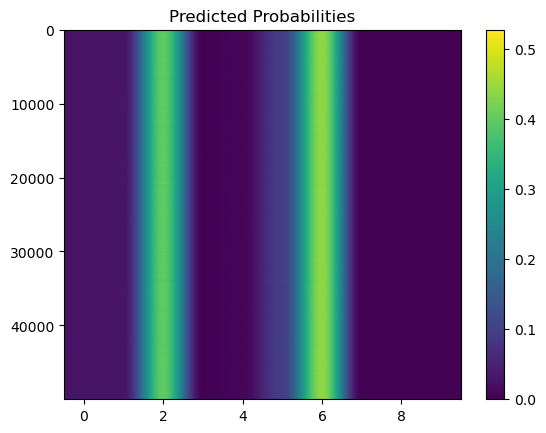

In [23]:
# Function to get the fitted pi values on the training data
def get_fitted_pi(model, device, data_loader):
    model.eval()
    all_pi = []
    all_labels = []

    with torch.no_grad():
        for data, digit, pos, _, _, _ in data_loader:
            data, pos = data.to(device), pos.to(device).unsqueeze(1)
            pred_pi, _, _ = model(data, pos)  # Get the predicted pi from the model
            all_pi.append(pred_pi.detach().cpu())  # Move the fitted pi values to CPU and detach
            all_labels.append(digit.cpu())  # Collect the labels

    # Concatenate all fitted pi values and labels
    all_pi = torch.cat(all_pi)
    all_labels = torch.cat(all_labels)
    
    return all_pi, all_labels

# Call this function after training to get the fitted pi values
fitted_pi, labels = get_fitted_pi(model, device, train_loader)

# Print some of the fitted pi values for the first few samples
print("Fitted pi values for the first few samples:")
print(fitted_pi[:10])
print("Corresponding labels for the first few samples:")
print(labels[:10])
plt.imshow(fitted_pi, aspect='auto')
plt.title('Predicted Probabilities')
plt.colorbar()